In [1]:
import pandas as pd
import numpy as np
import time
import urllib.request
import os
import pickle
from os import path
from csv import writer

import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional,Activation

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import xgboost as xgb

In [2]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [3]:
Kospi_50 = pd.DataFrame({'종목코드':['005930', '000660', '207940', '051910', '006400'
                                    , '005380', '000270', '207940', '005490', '035420'
                                    , '003670', '035720', '068270', '012330', '066570'
                                    , '028260', '105560', '055550', '096770', '032830'
                                    , '034730', '086790', '015760', '034020', '033780'
                                    , '000810', '009150', '017670', '010130', '018260'
                                    , '011200', '138040', '316140', '010950', '051900'
                                    , '009830', '003490', '024110', '030200', '011170'
                                    , '011070', '009540', '036570', '086280', '047050'
                                    , '090430', '241560', '034220','010140', '028050'],
                             '종목명':['삼성전자', 'SK하이닉스', '삼성바이오로직스', 'LG화학', '삼성SDI'
                                   , '현대차', '기아', '삼성바이오로직스', 'POSCO홀딩스', 'NAVER'
                                   , '포스코퓨처엠', '카카오', '셀트리온', '현대모비스', 'LG전자'
                                   , '삼성물산', 'KB금융', '신한지주', 'SK이노베이션', '삼성생명'
                                   , 'SK', '하나금융지주', '한국전력', '두산에너빌리티', 'KT&G'
                                   , '삼성화재', '삼성전기', 'SK텔레콤', '고려아연', '삼성에스디에스'
                                   , 'HMM', '메리츠금융지주', '우리금융지주', 'S-Oil', 'LG생활건강'
                                   , '한화솔루션', '대한항공', '기업은행', 'KT', '롯데케미칼'
                                   , 'LG이노텍', 'HD한국조선해양', '엔씨소프트', '현대글로비스', '포스코인터내셔널'
                                   , '아모레퍼시픽', '두산밥캣','LG디스플레이','삼성중공업','삼성엔지니어링']})

In [4]:
LSRMnum=[0,1,3,4,11,12,14,18,23,34,40,41,44,45,47,48]
xgbnum=[0,1,3,4,11,12,18,23,30,35,36,40,41,45,47,48]

In [5]:
LSTM_Kospi_50=Kospi_50.loc[LSRMnum]
xgb_Kospi_50=Kospi_50.loc[xgbnum]

In [6]:
xgb_Kospi_50['RMSE_xgb']=np.nan
xgb_Kospi_50['R2_xgb']=np.nan

LSTM_Kospi_50['RMSE_LSTM']=np.nan
LSTM_Kospi_50['R2_LSTM']=np.nan

In [34]:
def BLSTM_text_fix(finnum,finname):
    
    print(finname)
    df = fdr.DataReader(f'{finnum}', '2021-07-01', '2023-06-30')

    dfx = df[['Open','High','Low','Volume', 'Close']]
    dfx = MinMaxScaler(dfx)
    dfx=dfx.reset_index()
    dfx


    data = pd.read_csv(f'D:\stock\감성분석/{finname}.csv',names=['Date','neutralP','negativeP','positiveP'])
    data.sort_values(by='Date', inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

    data = data.groupby('Date').agg({
        'neutralP': lambda x: sum(x) / 2,
        'negativeP': lambda x: sum(x) / 2,
        'positiveP': lambda x: sum(x) / 2
    }).reset_index()

    data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
    dfx2 = pd.merge(dfx, data, on='Date', how='outer')
    dfx2=dfx2.dropna(subset = ['Open','negativeP'])
    dfx2=dfx2.set_index(keys='Date')
    
    dfy = dfx2[['Close']]
    dfx2 = dfx2[['Open','High','Low','Volume','negativeP','positiveP']]

    X = dfx2.values.tolist()
    y = dfy.values.tolist()

    window_size = 10

    data_X = []
    data_y = []
    for i in range(len(y) - window_size):
        _X = X[i : i + window_size] 
        _y = y[i + window_size]     
        data_X.append(_X)
        data_y.append(_y)
    
    n=len(data_y)

    train_X = np.array(data_X[0:int(n*0.7)])
    train_y = np.array(data_y[0:int(n*0.7)])

    val_X = np.array(data_X[int(n*0.7):int(n*0.9)])
    val_y = np.array(data_y[int(n*0.7):int(n*0.9)])

    test_X = np.array(data_X[int(n*0.9):])
    test_y = np.array(data_y[int(n*0.9):])

    model2 = Sequential()


    forward_layer = LSTM(64, return_sequences=True)
    backward_layer = LSTM(64, activation='relu', return_sequences=True,
                          go_backwards=True)

    model2.add(Bidirectional(forward_layer, backward_layer=backward_layer,
                            input_shape=(10, 6)))

    model2.add(Dropout(0.2))

    model2.add(Bidirectional(LSTM(64)))

    model2.add(Dropout(0.2))

    model2.add(Dense(units=1))

    validation_data = (val_X,val_y)


    model2.compile(optimizer='adam', 
                  loss='mean_squared_error',
                  metrics=['mae','acc']
                 )
    model2.fit(train_X, 
              train_y, 
              epochs=300, 
              batch_size=30,
              validation_data=validation_data
             )
    
    pred_y = model2.predict(test_X)
    RMSE_predict=np.sqrt(mean_squared_error(test_y, pred_y))
    f2_y_predict = r2_score(test_y, pred_y)
    
    print(finname+'끝')
    
    return RMSE_predict,f2_y_predict

In [35]:
for i in range(0,len(xgb_Kospi_50)):
    RMSE,R2=BLSTM_text_fix(LSTM_Kospi_50.iloc[i,0],LSTM_Kospi_50.iloc[i,1])
    LSTM_Kospi_50.iloc[i,2]=RMSE
    LSTM_Kospi_50.iloc[i,3]=R2

삼성전자
Epoch 1/200
12/12 [==============================] - 8s 144ms/step - loss: 0.0740 - mae: 0.2076 - acc: 0.0030 - val_loss: 0.0027 - val_mae: 0.0450 - val_acc: 0.0000e+00
Epoch 2/200
12/12 [==============================] - 0s 23ms/step - loss: 0.0143 - mae: 0.0919 - acc: 0.0059 - val_loss: 0.0032 - val_mae: 0.0479 - val_acc: 0.0000e+00
Epoch 3/200
12/12 [==============================] - 0s 23ms/step - loss: 0.0095 - mae: 0.0789 - acc: 0.0059 - val_loss: 0.0026 - val_mae: 0.0435 - val_acc: 0.0000e+00
Epoch 4/200
12/12 [==============================] - 0s 23ms/step - loss: 0.0074 - mae: 0.0683 - acc: 0.0059 - val_loss: 0.0028 - val_mae: 0.0455 - val_acc: 0.0000e+00
Epoch 5/200
12/12 [==============================] - 0s 24ms/step - loss: 0.0063 - mae: 0.0629 - acc: 0.0059 - val_loss: 0.0039 - val_mae: 0.0494 - val_acc: 0.0000e+00
Epoch 6/200
12/12 [==============================] - 0s 23ms/step - loss: 0.0056 - mae: 0.0581 - acc: 0.0059 - val_loss: 0.0027 - val_mae: 0.0438 - val_ac

median: 0.7847850380824866
mean: 0.7508879230925375


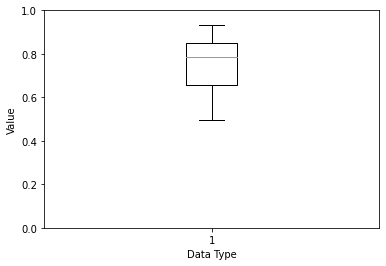

In [46]:
import matplotlib.pyplot as plt
import statistics

fig, ax = plt.subplots()

box = ax.boxplot(LSTM_Kospi_50['R2_LSTM'])
ax.set_ylim(0, 1.0)
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')

medians = [item.get_ydata() for item in box['medians']]
mean_value = sum(LSTM_Kospi_50['R2_LSTM']) / len(LSTM_Kospi_50['R2_LSTM'])

# 중앙값을 계산
median_value = statistics.median(LSTM_Kospi_50['R2_LSTM'])

print('median:', median_value)
print('mean:', mean_value)

plt.show()

In [47]:
LSTM_Kospi_50

,종목코드,종목명,RMSE_LSTM,R2_LSTM
0,005930,삼성전자,0.041305,0.844250
1,000660,SK하이닉스,0.084821,0.837851
3,051910,LG화학,0.037757,0.637440
4,006400,삼성SDI,0.048032,0.561851
11,035720,카카오,0.013877,0.698758
12,068270,셀트리온,0.026666,0.665879
14,066570,LG전자,0.034458,0.788717
18,096770,SK이노베이션,0.028272,0.868598
23,034020,두산에너빌리티,0.046487,0.780853
34,051900,LG생활건강,0.012393,0.891476


In [48]:
LSTM_Kospi_50.to_excel('./LSTM혐오.xlsx', index=False)

In [62]:
def xgb_text_fix(finnum,finname):
    
    print(finname)
    df = fdr.DataReader(f'{finnum}', '2021-07-01', '2023-06-30')

    dfx = df[['Open','High','Low','Volume', 'Close']]
    dfx = MinMaxScaler(dfx)
    dfx=dfx.reset_index()
    dfx


    data = pd.read_csv(f'D:\stock\감성분석/{finname}.csv',names=['Date','neutralP','negativeP','positiveP'])
    data.sort_values(by='Date', inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

    data = data.groupby('Date').agg({
        'neutralP': lambda x: sum(x) / 2,
        'negativeP': lambda x: sum(x) / 2,
        'positiveP': lambda x: sum(x) / 2
    }).reset_index()

    data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
    dfx2 = pd.merge(dfx, data, on='Date', how='outer')
    dfx2=dfx2.dropna(subset = ['Open','negativeP'])
    dfx2=dfx2.set_index(keys='Date')
    
    dfy = dfx2[['Close']]
    dfx2 = dfx2[['Open','High','Low','Volume','negativeP','positiveP']]

    X = dfx2.values.tolist()
    y = dfy.values.tolist()

    window_size = 10

    data_X = []
    data_y = []
    for i in range(len(y) - window_size):
        _X = X[i : i + window_size] 
        _y = y[i + window_size]     
        data_X.append(_X)
        data_y.append(_y)
    
    n=len(data_y)

    train_X = np.array(data_X[0:int(n*0.7)])
    train_Xnum=train_X.shape
    train_X=train_X.reshape(train_Xnum[0],train_Xnum[1]*train_Xnum[2])
    
    train_y = np.array(data_y[0:int(n*0.7)])

    

    val_X = np.array(data_X[int(n*0.7):int(n*0.9)])
    val_Xnum=val_X.shape
    val_X=val_X.reshape(val_Xnum[0],val_Xnum[1]*val_Xnum[2])
    
    val_y = np.array(data_y[int(n*0.7):int(n*0.9)])


    test_X = np.array(data_X[int(n*0.9):])
    test_Xnum=test_X.shape
    test_X=test_X.reshape(test_Xnum[0],test_Xnum[1]*test_Xnum[2])
    
    test_y = np.array(data_y[int(n*0.9):])
    
    
    validation_data = (val_X,val_y)

    my_model = xgb.XGBRegressor(learning_rate=0.1,max_depth=3,n_estimators=100)

    my_model.fit(train_X, train_y, verbose=False)
    
    
    pred_y = my_model.predict(test_X)
    
    RMSE_predict=np.sqrt(mean_squared_error(test_y, pred_y))
    f2_y_predict = r2_score(test_y, pred_y)
    
    print(finname+'끝')
    
    return RMSE_predict,f2_y_predict

In [63]:
for i in range(0,len(xgb_Kospi_50)):
    RMSE,R2=xgb_text_fix(xgb_Kospi_50.iloc[i,0],xgb_Kospi_50.iloc[i,1])
    xgb_Kospi_50.iloc[i,2]=RMSE
    xgb_Kospi_50.iloc[i,3]=R2

삼성전자
삼성전자끝
SK하이닉스
SK하이닉스끝
LG화학
LG화학끝
삼성SDI
삼성SDI끝
카카오
카카오끝
셀트리온
셀트리온끝
SK이노베이션
SK이노베이션끝
두산에너빌리티
두산에너빌리티끝
HMM
HMM끝
한화솔루션
한화솔루션끝
대한항공
대한항공끝
LG이노텍
LG이노텍끝
HD한국조선해양
HD한국조선해양끝
아모레퍼시픽
아모레퍼시픽끝
LG디스플레이
LG디스플레이끝
삼성중공업
삼성중공업끝


In [64]:
xgb_Kospi_50

,종목코드,종목명,RMSE_xgb,R2_xgb
0,005930,삼성전자,0.050230,0.769672
1,000660,SK하이닉스,0.054550,0.932933
3,051910,LG화학,0.042370,0.543441
4,006400,삼성SDI,0.042164,0.662375
11,035720,카카오,0.013822,0.701145
12,068270,셀트리온,0.027178,0.652939
18,096770,SK이노베이션,0.037346,0.770717
23,034020,두산에너빌리티,0.048932,0.757202
30,011200,HMM,0.018758,0.702297
35,009830,한화솔루션,0.048163,0.791177


median: 0.729749379664304
mean: 0.6993932620023463


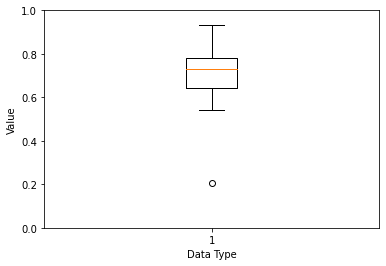

In [66]:
fig, ax = plt.subplots()

box = ax.boxplot(xgb_Kospi_50['R2_xgb'])
ax.set_ylim(0, 1.0)
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')

medians = [item.get_ydata() for item in box['medians']]
mean_value = sum(xgb_Kospi_50['R2_xgb']) / len(xgb_Kospi_50['R2_xgb'])

# 중앙값을 계산
median_value = statistics.median(xgb_Kospi_50['R2_xgb'])

print('median:', median_value)
print('mean:', mean_value)


plt.show()

In [67]:
xgb_Kospi_50

,종목코드,종목명,RMSE_xgb,R2_xgb
0,005930,삼성전자,0.050230,0.769672
1,000660,SK하이닉스,0.054550,0.932933
3,051910,LG화학,0.042370,0.543441
4,006400,삼성SDI,0.042164,0.662375
11,035720,카카오,0.013822,0.701145
12,068270,셀트리온,0.027178,0.652939
18,096770,SK이노베이션,0.037346,0.770717
23,034020,두산에너빌리티,0.048932,0.757202
30,011200,HMM,0.018758,0.702297
35,009830,한화솔루션,0.048163,0.791177


In [38]:
LSTM_Kospi_50.to_excel('./LSTM혐오.xlsx', index=False)

In [68]:
xgb_Kospi_50.to_excel('./XGB혐오.xlsx', index=False)